## Numerical solver for the HJB problem

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Parameters
T = 1.0            # terminal time
dt = 0.01          # time step
dx = 0.5           # inventory grid step
dp = 0.5           # price grid step
eta_T = 0.1        # temporary impact
eta_P = 0.1        # permanent impact
psi = 0.5          # half-spread
mu_P = 0.0         # drift
sigma_P = 1.0      # volatility

# Grid
X_vals = np.arange(-10, 10 + dx, dx)
P_vals = np.arange(0, 20 + dp, dp)
t_vals = np.arange(0, T + dt, dt)
NX, NP, NT = len(X_vals), len(P_vals), len(t_vals)

# Initialize value function
V = np.zeros((NT, NX, NP))
opt_q = np.zeros_like(V)

# Terminal condition (e.g., penalty for imbalance between inventory and demand, here demand=0)
V[-1, :, :] = np.abs(X_vals[:, None])  # penalty = |inventory| at T

# Main finite difference loop (backward in time)
for n in reversed(range(NT - 1)):
    t = t_vals[n]
    for i in range(1, NX - 1):
        for j in range(1, NP - 1):
            X = X_vals[i]
            P = P_vals[j]

            # Derivatives
            dV_dX = (V[n + 1, i + 1, j] - V[n + 1, i - 1, j]) / (2 * dx)
            dV_dP = (V[n + 1, i, j + 1] - V[n + 1, i, j - 1]) / (2 * dp)
            d2V_dP2 = (V[n + 1, i, j + 1] - 2 * V[n + 1, i, j] + V[n + 1, i, j - 1]) / (dp ** 2)

            # Objective function for q
            def HJB_objective(q):
                mid_price = P
                execution_price = mid_price + np.sign(q) * psi + eta_T * q
                reward = -q * execution_price + q * dV_dX + eta_P * q * dV_dP
                return reward

            # Optimize control
            res = minimize_scalar(lambda q: -HJB_objective(q), bounds=(-10, 10), method='bounded')
            q_star = res.x
            opt_q[n, i, j] = q_star

            # Dynamics
            drift_P = mu_P + eta_P * q_star
            diffusion_P = sigma_P

            # Update value function using explicit Euler
            dX = -q_star * dV_dX
            dP = -drift_P * dV_dP
            diffusion_term = 0.5 * diffusion_P ** 2 * d2V_dP2
            reward = -q_star * (P + np.sign(q_star) * psi + eta_T * q_star)

            V[n, i, j] = V[n + 1, i, j] + dt * (reward + dX + dP + diffusion_term)


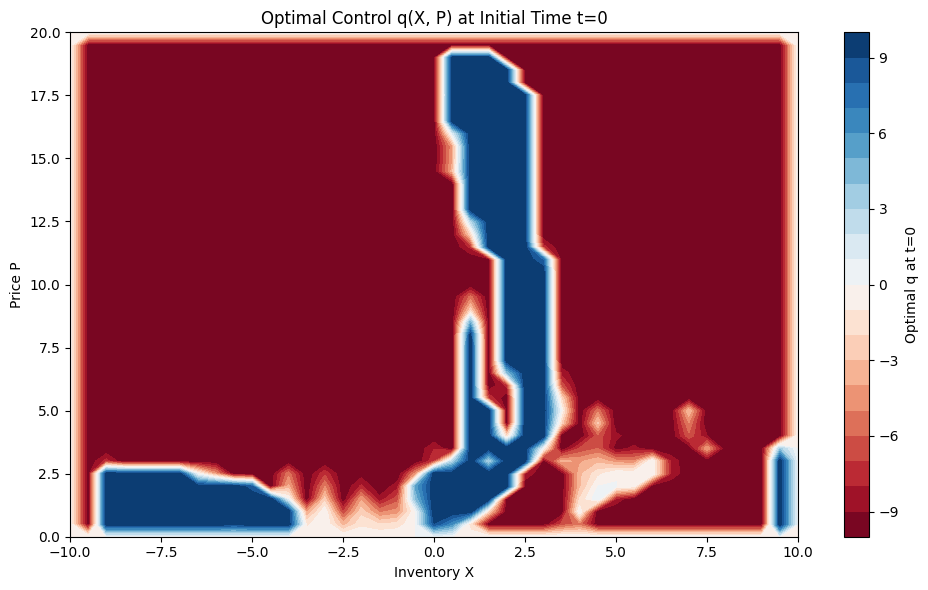

In [2]:
# Plotting optimal control at t=0 for visualization
plt.figure(figsize=(10, 6))
X_grid, P_grid = np.meshgrid(X_vals, P_vals, indexing='ij')
plt.contourf(X_grid, P_grid, opt_q[0], levels=20, cmap='RdBu')
plt.colorbar(label='Optimal q at t=0')
plt.xlabel('Inventory X')
plt.ylabel('Price P')
plt.title('Optimal Control q(X, P) at Initial Time t=0')
plt.tight_layout()
plt.show()